In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
from yelp.client import Client
import json
from ratelimit import limits
import requests
import csv
import random
from keys import my_api_key, gkey
import gmaps

%matplotlib inline

## Read in Census data

In [618]:
# read in cleaned census data and subset the data to segment rural (population > 1000 & < 50000 + exclude primitive locations)
# urban (population > 50000) areas. Once data was subset, took 100 random samples from both data sets


In [432]:
df = pd.read_csv("../sub-est2019_all.csv", engine='python')
rural_city = df[(df["POPESTIMATE2019"]< 50000) & (df["POPESTIMATE2019"] > 1000) & (df["PRIMGEO_FLAG"]==0)]
rural_df = rural_city[["NAME", "STNAME", "POPESTIMATE2019"]]
urban_city = df[df["POPESTIMATE2019"]>= 50000]
urban_df = urban_city[["NAME", "STNAME", "POPESTIMATE2019"]]
urban_index = urban_df.loc[urban_df["NAME"] == urban_df["STNAME"]].index
urban_clean = urban_df.drop(urban_index)
random_urban_city = urban_clean[["NAME", "STNAME","POPESTIMATE2019"]].sample(n=100, random_state=1)
random_rural_city = rural_df[["NAME", "STNAME", "POPESTIMATE2019"]].sample(n=100, random_state=1)

## Yelp API calls

In [ ]:
# Looped through city and state names from the urban and rural dataframes to call Yelp API business search parameters.
# Set search radius of each call to be 5 miles (standard delivery distance).
# Used nested loop for offset parameter in order to pull multiple pages of results per search
# For each loop, returned search term, city, state, lat, lng, rest. name, category, and transactions & assigned them to dict

In [78]:
headers = {'Authorization': 'Bearer %s' % my_api_key}

rural_dict = {
    "Searched": [],
    "City": [],
    "State": [],
    "Lat": [],
    "Lng": [],
    "Restaurant": [],
    "Category": [],
#     "Category 2": [],
#     "Category 3": [],
    "Transactions":[]
}

url='https://api.yelp.com/v3/businesses/search'
offset = np.arange(0,950,50).tolist() 

for city, state in zip(random_rural_city["NAME"], random_rural_city["STNAME"]):
    for i in range(len(offset)):
        params = {
            'term': 'restaurant',
            'location': f"{city}, {state}",
            'radius': 8047,
            'limit': 50,
            'offset': offset[i]
                 }
        response = requests.get(url, params = params, headers = headers).json()
        try:
            for business in range(len(response["businesses"])):
                try:
                    rural_dict["Searched"].append(f"{city}, {state}")
                    rural_dict["City"].append(response["businesses"][business]["location"]["city"])
                    rural_dict["State"].append(response["businesses"][business]["location"]["state"])
                    rural_dict["Lat"].append(response["businesses"][business]["coordinates"]["latitude"])
                    rural_dict["Lng"].append(response["businesses"][business]["coordinates"]["longitude"])
                    rural_dict["Restaurant"].append(response["businesses"][business]["name"])
                    rural_dict["Category"].append([response["businesses"][business]["categories"][i]["title"] for i in range(len(response["businesses"][business]["categories"]))])
#                     rural_dict["Category"].append(response["businesses"][business]["categories"][0]["title"])
#                     rural_dict["Category 2"].append(response["businesses"][business]["categories"][1]["title"])
#                     rural_dict["Category 3"].append(response["businesses"][business]["categories"][2]["title"])
                    rural_dict["Transactions"].append(response["businesses"][business]["transactions"])
                except KeyError:
                    rural_dict["Searched"].append("No City Found")
                    rural_dict["City"].append("No City Found")
                    rural_dict["State"].append("No State Found")
                    rural_dict["Lat"].append("No Lat Found")
                    rural_dict["Lng"].append("No Lng Found")
                    rural_dict["Restaurant"].append("No Restaurant Found")
                    rural_dict["Category"].append("No Categories")
                    rural_dict["Transactions"].append("No Transactions Found")
#                 except IndexError:
#                     rural_dict["Category 2"].append("")
#                     rural_dict["Category 3"].append("")
        except KeyError:
                pass

In [79]:
#convert dict to dataframe
rural = pd.DataFrame.from_dict(rural_dict, orient='index')
rural = rural.transpose()
rural.head()

,Searched,City,State,Lat,Lng,Restaurant,Category,Transactions
0,"Parker, Arizona",Parker,AZ,34.1508,-114.291,Tierra Caliente,[Mexican],[]
1,"Parker, Arizona",Parker,AZ,34.2319,-114.188,Roadrunner Floating Dock Bar,"[Bars, Seafood, American (Traditional)]",[]
2,"Parker, Arizona",Parker,AZ,34.1843,-114.226,Mi Tierra,[Mexican],[]
3,"Parker, Arizona",Parker,AZ,34.2166,-114.202,Stroke's Bar & Grill,"[Bars, American (Traditional), Steakhouses]",[]
4,"Parker, Arizona",Parker,AZ,34.2245,-114.192,Pirate's Den Bar & Grill,"[American (Traditional), Bars, Steakhouses]",[]


In [74]:
#urban API call loop
headers = {'Authorization': 'Bearer %s' % my_api_key}

urban_dict = {
    "Searched": [],
    "City": [],
    "State": [],
    "Lat": [],
    "Lng": [],
    "Restaurant": [],
    "Category": [],
#     "Category 2": [],
#     "Category 3": [],
    "Transactions":[]
}

url='https://api.yelp.com/v3/businesses/search'
offset = np.arange(0,950,50).tolist() 

for city, state in zip(random_urban_city["NAME"], random_urban_city["STNAME"]):
    for i in range(len(offset)):
        params = {
            'term': 'restaurant',
            'location': f"{city}, {state}",
            'radius': 8047,
            'limit': 50,
            'offset': offset[i]
                 }
        response = requests.get(url, params = params, headers = headers).json()
        try:
            for business in range(len(response["businesses"])):
                try:
                    urban_dict["Searched"].append(f"{city}, {state}")
                    urban_dict["City"].append(response["businesses"][business]["location"]["city"])
                    urban_dict["State"].append(response["businesses"][business]["location"]["state"])
                    urban_dict["Lat"].append(response["businesses"][business]["coordinates"]["latitude"])
                    urban_dict["Lng"].append(response["businesses"][business]["coordinates"]["longitude"])
                    urban_dict["Restaurant"].append(response["businesses"][business]["name"])
                    urban_dict["Category"].append([response["businesses"][business]["categories"][i]["title"] for i in range(len(response["businesses"][business]["categories"]))])
#                     rural_dict["Category"].append(response["businesses"][business]["categories"][0]["title"])
#                     rural_dict["Category 2"].append(response["businesses"][business]["categories"][1]["title"])
#                     rural_dict["Category 3"].append(response["businesses"][business]["categories"][2]["title"])
                    urban_dict["Transactions"].append(response["businesses"][business]["transactions"])
                except KeyError:
                    urban_dict["Searched"].append("No City Found")
                    urban_dict["City"].append("No City Found")
                    urban_dict["State"].append("No State Found")
                    urban_dict["Lat"].append("No Lat Found")
                    urban_dict["Lng"].append("No Lng Found")
                    urban_dict["Restaurant"].append("No Restaurant Found")
                    urban_dict["Category"].append("No Categories")
                    urban_dict["Transactions"].append("No Transactions Found")
#                 except IndexError:
#                     rural_dict["Category 2"].append("")
#                     rural_dict["Category 3"].append("")
        except KeyError:
                pass

In [75]:
#convert dict to dataframe
urban = pd.DataFrame.from_dict(urban_dict, orient='index')
urban = urban.transpose()
urban.head()

,Searched,City,State,Lat,Lng,Restaurant,Category,Transactions
0,"Montgomery, Alabama",Montgomery,AL,32.357,-86.2649,Cork & Cleaver,[Gastropubs],"[pickup, delivery]"
1,"Montgomery, Alabama",Montgomery,AL,32.3802,-86.3106,Central,"[Bars, American (Traditional), Venues & Event ...",[delivery]
2,"Montgomery, Alabama",Montgomery,AL,32.3797,-86.3108,Sa Za,[Italian],"[restaurant_reservation, delivery]"
3,"Montgomery, Alabama",Montgomery,AL,32.3489,-86.22,Baumhower's Victory Grille,"[Chicken Wings, American (Traditional), Sports...",[delivery]
4,"Montgomery, Alabama",Montgomery,AL,32.3543,-86.2161,So Gong Dong Tofu & BBQ,[Korean],[delivery]


In [81]:
#export dataframes to csv files
urban.to_csv("../urban.csv")
rural.to_csv("../rural.csv")

## Subset and Transform API data

In [83]:
#transform "Category" row list contents to individual columns and drop empty cells
rural_cat= pd.DataFrame(rural["Category"].to_list(), columns = ["Category 1", "Category 2", "Category 3"], index = rural.index)
rural_cats = rural_cat[["Category 1", "Category 2", "Category 3"]]
rural_clean = rural.merge(rural_cats, left_index = True,right_index = True)

In [84]:
#transform "Category" row list contents to individual columns and drop empty cells
urban_cat= pd.DataFrame(urban["Category"].to_list(), columns = ["Category 1", "Category 2", "Category 3", "Category 4"], index = urban.index)
urban_cats = urban_cat[["Category 1", "Category 2", "Category 3"]]
urban_clean = urban.merge(urban_cats, left_index = True,right_index = True)


In [87]:
urban_clean.head()

,Searched,City,State,Lat,Lng,Restaurant,Category,Transactions,Category 1,Category 2,Category 3
0,"Montgomery, Alabama",Montgomery,AL,32.357,-86.2649,Cork & Cleaver,[Gastropubs],"[pickup, delivery]",Gastropubs,None,None
1,"Montgomery, Alabama",Montgomery,AL,32.3802,-86.3106,Central,"[Bars, American (Traditional), Venues & Event ...",[delivery],Bars,American (Traditional),Venues & Event Spaces
2,"Montgomery, Alabama",Montgomery,AL,32.3797,-86.3108,Sa Za,[Italian],"[restaurant_reservation, delivery]",Italian,None,None
3,"Montgomery, Alabama",Montgomery,AL,32.3489,-86.22,Baumhower's Victory Grille,"[Chicken Wings, American (Traditional), Sports...",[delivery],Chicken Wings,American (Traditional),Sports Bars
4,"Montgomery, Alabama",Montgomery,AL,32.3543,-86.2161,So Gong Dong Tofu & BBQ,[Korean],[delivery],Korean,None,None


In [88]:
#subset urban and rural dataframes to only vegan restaurants
keywords = ["Vegan", "vegan"]
rural_vegan = rural_clean[(rural_clean["Category 1"].isin(keywords))|(rural_clean["Category 2"].isin(keywords))|(rural_clean["Category 3"].isin(keywords))]
urban_vegan = urban_clean[(urban_clean["Category 1"].isin(keywords))|(urban_clean["Category 2"].isin(keywords))|(urban_clean["Category 3"].isin(keywords))]

In [89]:
#append new column to dataframe that identifies (true = 1, false = 0) if category cells within row contain keywords
rural_clean["Vegan Options"] = np.where(rural_clean["Category 1"].isin(keywords)|rural_clean["Category 2"].isin(keywords)|rural_clean["Category 3"].isin(keywords), 1, 0)
urban_clean["Vegan Options"] = np.where(urban_clean["Category 1"].isin(keywords)|urban_clean["Category 2"].isin(keywords)|urban_clean["Category 3"].isin(keywords), 1, 0)


In [90]:
#export dataframe to csv
rural_clean.to_csv("../Data Pull/rural_clean.csv")
urban_clean.to_csv("../Data Pull/urban_clean.csv")

## Merge Census 2019 population data with urban and rural yelp dataframes

In [91]:
#add "Searched" column to census dataframe to have common column on which to join both dataframes
df["Searched"] = df["NAME"] + ", " + df["STNAME"]

In [106]:
rural_clean_pop = pd.merge(rural_clean, df[["POPESTIMATE2019", "Searched"]],  how='left', on= "Searched")
urban_clean_pop = pd.merge(urban_clean, df[["POPESTIMATE2019", "Searched"]],  how='left', on= "Searched")
urban_clean_pop.drop_duplicates(subset = ['Searched', 'Restaurant'], keep = 'first')
rural_clean_pop.drop_duplicates(subset = ['Searched', 'Restaurant'], keep = 'first')
urban_clean_pop.to_csv("../Data Pull/urban_clean_pop.csv")
rural_clean_pop.to_csv("../Data Pull/rural_clean_pop.csv")

In [122]:
#group by location searched
rural_group = rural_clean_pop.groupby("Searched")

#create variables based on data from grouped df
rural_rest_count = rural_group["Restaurant"].count()
rural_vegan_count = rural_group["Vegan Options"].sum()
rural_pop = rural_group["POPESTIMATE2019"].max()
vegan_pct = rural_vegan_count/rural_rest_count * 100
vegan_percap = rural_vegan_count/rural_pop

#create dataframe from dict of lists
rural_summary = pd.DataFrame({
    "Population" : rural_pop,
    "Total Restaurants" : rural_rest_count,
    "Vegan Restaurants" : rural_vegan_count,
    "% Vegan Restaurants" : vegan_pct,
    "Vegan Restaurants per capita" : vegan_percap
})

#reset index and export to csv
rural_summary = rural_summary.reset_index()
rural_summary.to_csv("../Data Pull/rural_summary.csv")
rural_summary.head()

,Searched,Population,Total Restaurants,Vegan Restaurants,% Vegan Restaurants,Vegan Restaurants per capita
0,"Americus, Georgia",15108,49,0,0.000000,0.000000
1,"Anchorage, Kentucky",2423,386,1,0.259067,0.000413
2,"Anderson, California",10630,48,0,0.000000,0.000000
3,"Ansonia, Ohio",1121,2,0,0.000000,0.000000
4,"Anthony, New Mexico",9239,31,0,0.000000,0.000000


In [108]:
#group by location searched
urban_group = urban_clean_pop.groupby("Searched")

#create variables based on data from grouped df
urban_rest_count = urban_group["Restaurant"].count()
urban_vegan_count = urban_group["Vegan Options"].sum()
urban_pop = urban_group["POPESTIMATE2019"].max()
vegan_pct = urban_vegan_count/urban_rest_count * 100
vegan_percap = urban_vegan_count/urban_pop

#create dataframe from dict of lists
urban_summary = pd.DataFrame({
    "Population" : urban_pop,
    "Total Restaurants" : urban_rest_count,
    "Vegan Restaurants" : urban_vegan_count,
    "% Vegan Restaurants" : vegan_pct,
    "Vegan Restaurants per capita" : vegan_percap
})

#reset index and export to csv
urban_summary.to_csv("../Data Pull/urban_summary.csv")
urban_summary = urban_summary.reset_index()
urban_summary.head()


,Searched,Population,Total Restaurants,Vegan Restaurants,% Vegan Restaurants,Vegan Restaurants per capita
0,"Asheville, North Carolina",92870,440,5,1.136364,0.000054
1,"Auburn, Washington",81464,302,0,0.000000,0.000000
2,"Aurora, Illinois",197757,294,0,0.000000,0.000000
3,"Austin, Texas",978908,950,26,2.736842,0.000027
4,"Baldwin Park, California",75251,950,5,0.526316,0.000066


In [114]:
#create avgerage summary dataframe
urban_tot_cities = urban_summary["Searched"].nunique()
urban_tot_pop = urban_summary["Population"].mean()
urban_tot_rest = urban_summary["Total Restaurants"].mean()
urban_tot_vegan = urban_summary["Vegan Restaurants"].mean()
urban_tot_per = urban_summary["% Vegan Restaurants"].mean()
urban_tot_percap = urban_summary["Vegan Restaurants per capita"].mean()

urban_tot_summary = pd.DataFrame({
    "Cities": urban_tot_cities,
    "Avg Population": round(urban_tot_pop),
    "Avg Restaurants": round(urban_tot_rest),
    "Avg Vegan Restaurants": round(urban_tot_vegan),
    "Avg % Vegan Restaurants": urban_tot_per,
    "Avg Vegan Restaurants per capita": urban_tot_percap
     
}, index = ["Total"])

urban_tot_summary["Avg % Vegan Restaurants"] = urban_tot_summary["Avg % Vegan Restaurants"].map("{:.2f}%".format)
urban_tot_summary



,Cities,Avg Population,Avg Restaurants,Avg Vegan Restaurants,Avg % Vegan Restaurants,Avg Vegan Restaurants per capita
Total,100,140131,441,4,0.62%,0.000032


In [123]:
#create avgerage summary dataframe
urban_tot_cities = urban_summary["Searched"].nunique()
urban_tot_pop = urban_summary["Population"].sum()
urban_tot_rest = urban_summary["Total Restaurants"].sum()
urban_tot_vegan = urban_summary["Vegan Restaurants"].sum()
urban_tot_per = (urban_tot_vegan/urban_tot_rest) * 100
urban_tot_percap = urban_tot_vegan/urban_tot_pop

urban_tot_summary = pd.DataFrame({
    "Cities": urban_tot_cities,
    "Tot Population": round(urban_tot_pop),
    "Tot Restaurants": round(urban_tot_rest),
    "Tot Vegan Restaurants": round(urban_tot_vegan),
    "Tot % Vegan Restaurants": urban_tot_per,
    "Tot Vegan Restaurants per capita": urban_tot_percap
     
}, index = ["Total"])

urban_tot_summary["Tot % Vegan Restaurants"] = urban_tot_summary["Tot % Vegan Restaurants"].map("{:.2f}%".format)
urban_tot_summary



,Cities,Tot Population,Tot Restaurants,Tot Vegan Restaurants,Tot % Vegan Restaurants,Tot Vegan Restaurants per capita
Total,100,14013106,44068,372,0.84%,0.000027


In [157]:
#create avgerage summary dataframe
rural_tot_cities = rural_summary["Searched"].nunique()
rural_tot_pop = rural_summary["Population"].mean()
rural_tot_rest = rural_summary["Total Restaurants"].mean()
rural_tot_vegan = rural_summary["Vegan Restaurants"].mean()
rural_tot_per = rural_summary["% Vegan Restaurants"].mean()
rural_tot_percap = rural_summary["Vegan Restaurants per capita"].mean()

rural_tot_summary = pd.DataFrame({
    "Cities": rural_tot_cities,
    "Avg Population": round(rural_tot_pop),
    "Avg Restaurants": round(rural_tot_rest),
    "Avg Vegan Restaurants": round(rural_tot_vegan,1),
    "Avg % Vegan Restaurants": rural_tot_per,
    "Avg Vegan Restaurants per capita": rural_tot_percap
     
}, index = ["Total"])

rural_tot_summary["Avg % Vegan Restaurants"] = rural_tot_summary["Avg % Vegan Restaurants"].map("{:.2f}%".format)
rural_tot_summary


,Cities,Avg Population,Avg Restaurants,Avg Vegan Restaurants,Avg % Vegan Restaurants,Avg Vegan Restaurants per capita
Total,98,6973,107,0.4,0.10%,0.000064


In [125]:
#create avgerage summary dataframe
rural_tot_cities = rural_summary["Searched"].nunique()
rural_tot_pop = rural_summary["Population"].sum()
rural_tot_rest = rural_summary["Total Restaurants"].sum()
rural_tot_vegan = rural_summary["Vegan Restaurants"].sum()
rural_tot_per = rural_tot_vegan/rural_tot_rest * 100
rural_tot_percap = rural_tot_vegan/rural_tot_pop

rural_tot_summary = pd.DataFrame({
    "Cities": rural_tot_cities,
    "Tot Population": round(rural_tot_pop),
    "Tot Restaurants": round(rural_tot_rest),
    "Tot Vegan Restaurants": round(rural_tot_vegan),
    "Tot % Vegan Restaurants": rural_tot_per,
    "Tot Vegan Restaurants per capita": rural_tot_percap
     
}, index = ["Total"])

rural_tot_summary["Tot % Vegan Restaurants"] = rural_tot_summary["Tot % Vegan Restaurants"].map("{:.2f}%".format)
rural_tot_summary

,Cities,Tot Population,Tot Restaurants,Tot Vegan Restaurants,Tot % Vegan Restaurants,Tot Vegan Restaurants per capita
Total,98,683384,10467,41,0.39%,0.00006


## Pie Charts

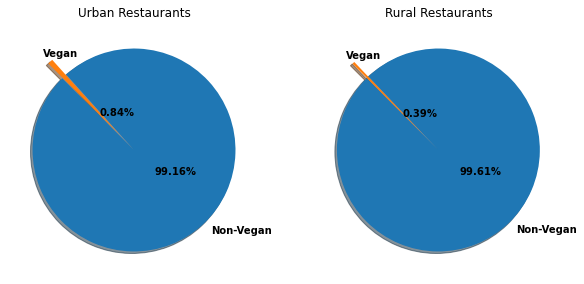

In [126]:
#create pie charts of vegan vs non-vegan restaurant counts in Urban and Rural datasets
rural_veg_group = rural_clean_pop.groupby("Vegan Options")
urban_veg_group = urban_clean_pop.groupby("Vegan Options")
rural_veg = rural_veg_group["Vegan Options"].count()
urban_veg = urban_veg_group["Vegan Options"].count()
all_labels = ["Non-Vegan", "Vegan"]
explode = (0, 0.2)
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(10,10))
ax1.pie(urban_veg, explode = explode, labels = all_labels, autopct = "%1.2f%%", pctdistance = 0.3, shadow = True, startangle =135, textprops = {'weight': 'bold', 'ha':'left'})
ax2.pie(rural_veg, explode = explode, labels = all_labels, autopct = "%1.2f%%", pctdistance = 0.3, shadow = True, startangle =135, textprops = {'weight': 'bold', 'ha':'left'})
ax1.set_title("Urban Restaurants")
ax2.set_title("Rural Restaurants")

plt.savefig("../Images/piechart.jpg", dpi = 100)
plt.show()


## Scatter plot

The correlation coefficient is 0.53


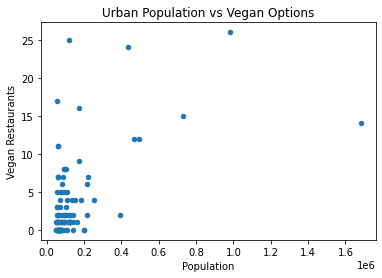

In [127]:
#create scatter plots comparing area population and count of vegan restaurants
urban_scatter = urban_summary[["Population", "Vegan Restaurants"]]
urban_scatter.plot(x="Population", y = "Vegan Restaurants", kind = "scatter", title = "Urban Population vs Vegan Options")
correlation = st.pearsonr(urban_summary["Population"], urban_summary["Vegan Restaurants"])
print(f"The correlation coefficient is {round(correlation[0],2)}")
plt.show()

The r-value is: 0.5311535229130344 & the correlation coefficient is 0.53


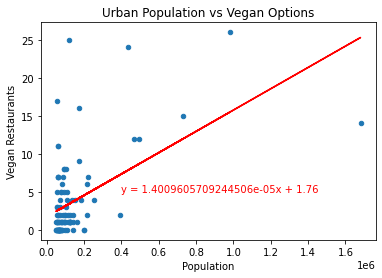

In [128]:
x_val = urban_summary["Population"]
y_val = urban_summary["Vegan Restaurants"]
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_val, y_val)
regress = slope * x_val + intercept
eq = f"y = {slope}x + {round(intercept,2)}"
urban_scatter.plot(x = "Population", y = "Vegan Restaurants", kind = "scatter", title = "Urban Population vs Vegan Options")
plt.plot(x_val, regress, "r-")
plt.annotate(eq, (400000,5), color ="r")
print(f"The r-value is: {rvalue} & the correlation coefficient is {round(correlation[0],2)}")
plt.savefig("../Images/urbanscatter.jpg", dpi = 100)
plt.show()

In [129]:
## plot shows a weak positive correlation between population and number of vegan restaurants in urban areas

The correlation coefficient is 0.41


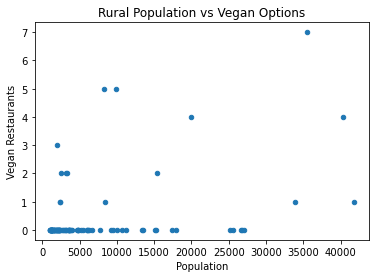

In [130]:
rural_scatter = rural_summary[["Population", "Vegan Restaurants"]]
rural_scatter.plot(x="Population", y = "Vegan Restaurants", kind = "scatter", title = "Rural Population vs Vegan Options")
correlation = st.pearsonr(rural_summary["Population"], rural_summary["Vegan Restaurants"])
print(f"The correlation coefficient is {round(correlation[0],2)}")
plt.show()

The r-value is: 0.4079222987270247 & the correlation coefficient is 0.41


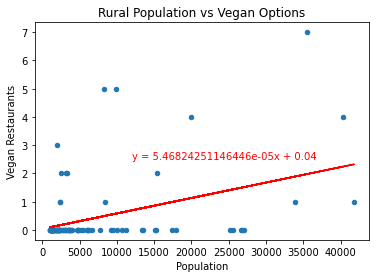

In [131]:
x_val = rural_summary["Population"]
y_val = rural_summary["Vegan Restaurants"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_val, y_val)
regress = slope * x_val + intercept
eq = f"y = {slope}x + {round(intercept,2)}"
rural_scatter.plot(x = "Population", y = "Vegan Restaurants", kind = "scatter", title = "Rural Population vs Vegan Options")
plt.plot(x_val, regress, "r-")
plt.annotate(eq, (12000,2.5), color ="r")
print(f"The r-value is: {rvalue} & the correlation coefficient is {round(correlation[0],2)}")
plt.savefig("../Images/ruralscatter.jpg", dpi = 100)
plt.show()

In [ ]:
## plot shows a weak positive correlation between population and number of vegan restaurants in rural areas

## Google Heat Maps

In [132]:
gmaps.configure(api_key = gkey)
urban_locations = pd.read_csv("../Data Pull/urban_clean.csv", index_col=0)
rural_locations = pd.read_csv("../Data Pull/rural_clean.csv", index_col=0)
rural_locations_df = rural_locations.copy()
rural_locations_df = rural_locations_df[rural_locations_df['Lat'] > 0]
urban_locations_df = urban_locations.copy()
urban_locations_df = urban_locations_df[urban_locations_df['Lat'] > 0]

In [133]:
rural_rest = rural_locations_df["Vegan Options"].astype(float)
rlocations = rural_locations_df[["Lat", "Lng"]].astype(float)

rural_fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(rlocations, weights=rural_rest, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)
rural_fig.add_layer(heat_layer)
rural_fig

Figure(layout=FigureLayout(height='420px'))

In [134]:
urban_rest = urban_locations_df["Vegan Options"].astype(float)
ulocations = urban_locations_df[["Lat", "Lng"]].astype(float)

urban_fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(ulocations, weights=urban_rest, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)
urban_fig.add_layer(heat_layer)
urban_fig
    

Figure(layout=FigureLayout(height='420px'))

In [135]:
combined = gmaps.figure()

urban_layer = gmaps.heatmap_layer(ulocations, weights=urban_rest, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)
rural_layer = gmaps.heatmap_layer(rlocations, weights=rural_rest, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

combined.add_layer(urban_layer)
combined.add_layer(rural_layer)
combined

Figure(layout=FigureLayout(height='420px'))

In [136]:
#plot location of vegan restaurants from urban and rural datasets 
urban_veg = urban_locations_df[urban_locations_df["Vegan Options"] == 1][["Restaurant","City","State","Lat","Lng"]]
rural_veg = rural_locations_df[rural_locations_df["Vegan Options"] == 1][["Restaurant","City","State","Lat","Lng"]]
veg_loc = pd.concat([urban_veg, rural_veg])

In [137]:
info_box_template = """
<dl>
<dt>Name</dt><dd>{Restaurant}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>State</dt><dd>{State}</dd>
</dl>
"""
veganrest_info = [info_box_template.format(**row) for index, row in veg_loc.iterrows()]
locations = veg_loc[["Lat", "Lng"]]

fig = gmaps.figure()
marker_layer = gmaps.marker_layer(locations, info_box_content=veganrest_info)
fig.add_layer(marker_layer)

fig

Figure(layout=FigureLayout(height='420px'))

## Bar Charts

In [138]:
top_5_urban =urban_summary.nlargest(5, ["Vegan Restaurants"])
top_5_urban

,Searched,Population,Total Restaurants,Vegan Restaurants,% Vegan Restaurants,Vegan Restaurants per capita
3,"Austin, Texas",978908,950,26,2.736842,0.000027
6,"Berkeley, California",121363,900,25,2.777778,0.000206
61,"Oakland, California",433031,950,24,2.526316,0.000055
27,"Fountain Valley, California",55357,950,17,1.789474,0.000307
28,"Garden Grove, California",171644,950,16,1.684211,0.000093


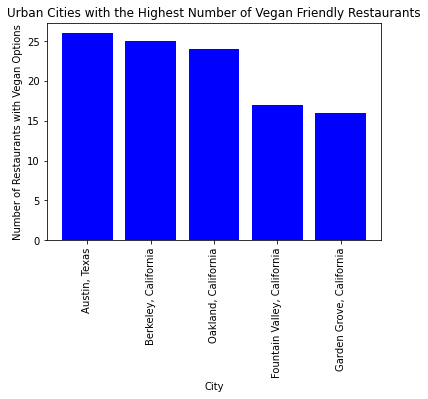

In [148]:
cities =  top_5_urban["Searched"]
vegan_rest= top_5_urban["Vegan Restaurants"]

#Create a bar chart of the data
plt.bar(cities, vegan_rest, color = "blue")
#Create titles
plt.xlabel("City")
plt.ylabel("Number of Restaurants with Vegan Options")
plt.title("Urban Cities with the Highest Number of Vegan Friendly Restaurants")
plt.xticks(rotation = "vertical")
plt.savefig("../Images/Urban Cities with the Highest Number of Vegan Friendly Restaurants.png",bbox_inches='tight')
plt.show()

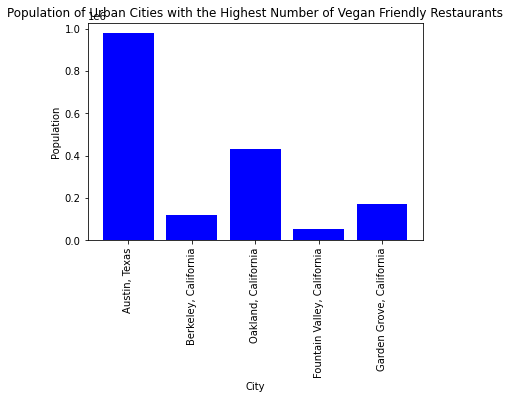

In [149]:
# Generate a bar plot showing the population vs. top 5 cities 

cities =  top_5_urban["Searched"]
population = top_5_urban["Population"]

#Create a bar chart of the data
plt.bar(cities, population, color = "blue")
#Create titles
plt.xlabel("City")
plt.ylabel("Population")
plt.title("Population of Urban Cities with the Highest Number of Vegan Friendly Restaurants")
plt.xticks(rotation = "vertical")
plt.savefig("../Images/Population of Urban Cities with the Highest Number of Vegan Friendly Restaurants.png",bbox_inches='tight')
plt.show()

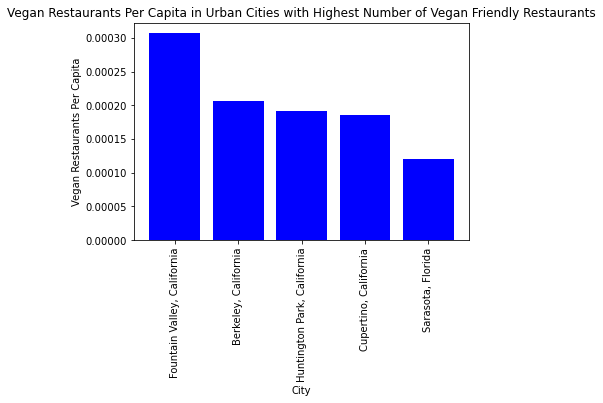

In [150]:
# Generate a bar plot showing the vegan options per capita vs. city name
top_5_urban_percap = urban_summary.nlargest(5, ["Vegan Restaurants per capita"])
cities =  top_5_urban_percap["Searched"]
per_capita = top_5_urban_percap["Vegan Restaurants per capita"]

#Create a bar chart of the data
plt.bar(cities, per_capita, color = "blue")
#Create titles
plt.xlabel("City")
plt.ylabel("Vegan Restaurants Per Capita")
plt.title("Vegan Restaurants Per Capita in Urban Cities with Highest Number of Vegan Friendly Restaurants")
plt.xticks(rotation = "vertical")
plt.savefig("../Images/Vegan Restaurants Per Capita in Urban Cities with Highest Number of Vegan Friendly Restaurants.png",bbox_inches='tight')
plt.show()

In [151]:
top_5_rural =rural_summary.nlargest(5, ["Vegan Restaurants"])
top_5_rural

,Searched,Population,Total Restaurants,Vegan Restaurants,% Vegan Restaurants,Vegan Restaurants per capita
74,"Riviera Beach, Florida",35463,526,7,1.330798,0.000197
37,"Haledon, New Jersey",8293,905,5,0.552486,0.000603
56,"Mission, Kansas",9911,702,5,0.712251,0.000504
19,"Covington, Kentucky",40341,770,4,0.519481,0.000099
65,"Orinda, California",19926,363,4,1.101928,0.000201


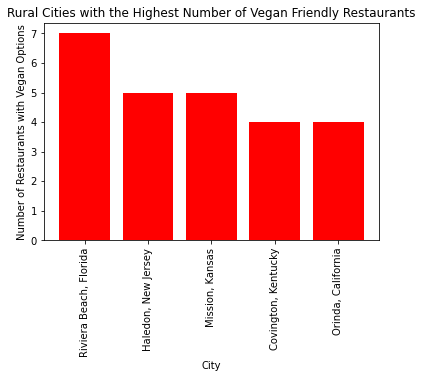

In [152]:
# Generate a bar plot showing the number of restaurants with vegan options vs. city name

rural_cities =  top_5_rural["Searched"]
rural_vegan_rest= top_5_rural["Vegan Restaurants"]

#Create a bar chart of the data
plt.bar(rural_cities, rural_vegan_rest, color = "red")
#Create titles
plt.xlabel("City")
plt.ylabel("Number of Restaurants with Vegan Options")
plt.title("Rural Cities with the Highest Number of Vegan Friendly Restaurants")
plt.xticks(rotation = "vertical")
plt.savefig("../Images/Rural Cities with the Highest Number of Vegan Friendly Restaurants.png",bbox_inches='tight')
plt.show()

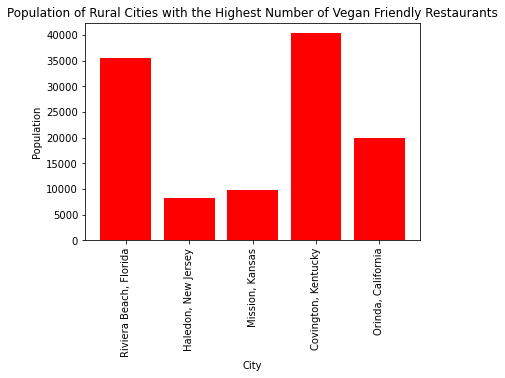

In [153]:
# Generate a bar plot showing the number of restaurants with vegan options vs. city name

rural_cities =  top_5_rural["Searched"]
rural_vegan_rest= top_5_rural["Vegan Restaurants"]
rural_pop = top_5_rural["Population"]
#Create a bar chart of the data
plt.bar(rural_cities, rural_pop, color = "red")
#Create titles
plt.xlabel("City")
plt.ylabel("Population")
plt.title("Population of Rural Cities with the Highest Number of Vegan Friendly Restaurants")
plt.xticks(rotation = "vertical")
plt.savefig("../Images/Population of Rural Cities with the Highest Number of Vegan Friendly Restaurants.png",bbox_inches='tight')
plt.show()

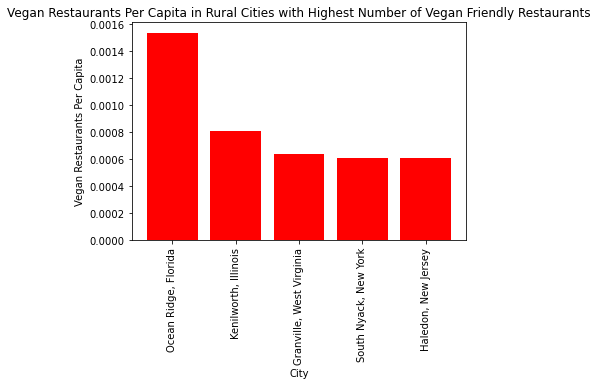

In [154]:
# Generate a bar plot showing the vegan options per capita vs. city name
top_5_rural_percap = rural_summary.nlargest(5, ["Vegan Restaurants per capita"])
cities =  top_5_rural_percap["Searched"]
per_capita = top_5_rural_percap["Vegan Restaurants per capita"]

#Create a bar chart of the data
plt.bar(cities, per_capita, color = "red")
#Create titles
plt.xlabel("City")
plt.ylabel("Vegan Restaurants Per Capita")
plt.title("Vegan Restaurants Per Capita in Rural Cities with Highest Number of Vegan Friendly Restaurants")
plt.xticks(rotation = "vertical")
plt.savefig("../Images/Vegan Restaurants Per Capita in Rural Cities with Highest Number of Vegan Friendly Restaurants.png",bbox_inches='tight')
plt.show()

## T-Test

In [155]:
urban_percapita = urban_summary["Vegan Restaurants per capita"].tolist()
rural_percapita = rural_summary["Vegan Restaurants per capita"].tolist()


In [156]:
st.ttest_ind(urban_percapita, rural_percapita, equal_var=False)
print(f"The p-value is: {pvalue}")

The p-value is: 3.05572315039022e-05


In [ ]:
# p-value of 3.1 e-05 suggests we can reject the null hypothesis and conclude that the number of vegan resturants in an area
# correlated with an increase in population